# Generates experimental figure in the paper

## This script assumes you have trained imagenet using `imagenet_train_crossval.py` for the conditions stored in the paper and then saved them in folders resnetX/model_name/model.pickle which we load and compute a forward pass to get the test accuracy.

In [2]:
# These imports enhance Python2/3 compatibility.
from __future__ import print_function, absolute_import, division, unicode_literals, with_statement

# Set-up imports and directories

In [3]:
import cleanlab
import numpy as np
import torch
import sys

# For visualizing images of label errors
from PIL import Image

# PyTorch stuff
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

# Standard imports
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Needed for computing the Clopper-Pearson exact confidence limits
from statsmodels.stats.proportion import proportion_confint

# urllib2 for python2 and python3
try:
    # For Python 3.0 and later
    from urllib.request import urlopen
except ImportError:
    # Fall back to Python 2's urllib2
    from urllib2 import urlopen  

# For plotting
import seaborn
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
    
# Where imagenet dataset is located
val_dir = '/datasets/datasets/imagenet/val/'
train_dir = '/datasets/datasets/imagenet/train/'

In [4]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


def parse_line(i):
    '''parses torch training logs for accuracies'''
    stuff = i[3:-1].split(" ")
    return (stuff[1], stuff[3])


def validate(val_loader, model, gpu):
    '''Computes validation accuracy for each class for a PyTorch model.'''
    
    # switch to evaluate mode
    model.eval()
    acc1s, acc5s = [], []
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            # Check that labels are all label i.
            assert(all(target.numpy() == i))
            print('\rProgress: {:.2%}'.format(i / 1000), end='')
            
            input = input.cuda(gpu, non_blocking=True)
            target = target.cuda(gpu, non_blocking=True)

            # compute output
            output = model(input)

            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            acc1s.append(acc1)
            acc5s.append(acc5)
    
    # Move from GPU to CPU
    acc1s = [z.cpu().numpy()[0] for z in acc1s]
    acc5s = [z.cpu().numpy()[0] for z in acc5s]

    return acc1s, acc5s

In [5]:
# Choose a GPU to use.
gpu = 0

In [6]:
# Get train set size
train_dataset = datasets.ImageFolder(train_dir)
imagenet_train_size = len(train_dataset.imgs)
del train_dataset

In [7]:
# Set-up validation data
val_dataset = datasets.ImageFolder(
    val_dir, 
    transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
)
imagenet_val_size = len(val_dataset.imgs)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=50, shuffle=False,
    num_workers=10, pin_memory=True,
)

In [8]:
# Set-up name mapping for ImageNet train data
url = 'https://gist.githubusercontent.com/aaronpolhamus/964a4411c0906315deb9f4a3723aac57/'
url += 'raw/aa66dd9dbf6b56649fa3fab83659b2acbf3cbfd1/map_clsloc.txt'
with urlopen(url) as f:
    lines = [x.decode('utf-8') for x in f.readlines()]    
    nid2name = dict([(l.split(" ")[0], l.split(" ")[2][:-1]) for l in lines])
    
nid2idx = val_dataset.class_to_idx
idx2nid = {v: k for k, v in nid2idx.items()}
name2nid = {v: k for k, v in nid2name.items()}
idx2name = {k: nid2name[v] for k, v in idx2nid.items()}
maillot_class_id = 639

In [9]:
# Fetch label errors identified with confident learning
label_error_mask = ~np.load("/home/cgn/masks/imagenet_train_bool_mask.npy")
num_label_errors = sum(np.array(label_error_mask, dtype=int))

# First we need to use confident learning to compute the confident joint

In [10]:
# Stores cross validated predicted probabilities for imagenet train set
pyx_file = 'imagenet__train__model_resnet50__pyx.npy' # trained from scratch with 10fold cv

# Stored results directory
pyx_dir = '/datasets/cgn/pyx/imagenet/'

# Load in data
pyx = np.load(pyx_dir + pyx_file)
imgs, labels = [list(z) for  z in zip(*datasets.ImageFolder(train_dir).imgs)]
labels = np.array(labels, dtype=int)

In [11]:
# Compute the confident joint
# Parallelized across all cores of your CPU. On a 20-core CPU, takes 30 seconds.
cj = cleanlab.latent_estimation.compute_confident_joint(labels, pyx)

In [12]:
# Compute an estimate of the true joint
# This won't affect results much, but you may use it instead of confident joint
joint = cleanlab.latent_estimation.estimate_joint(labels, pyx, confident_joint=cj)
joint_non_diag = joint - np.eye(len(joint)) * joint.diagonal()

In [13]:
# Compute a list of the (row,column) indices with largest non-digonal value (most noise)
cj_non_diag = cj - np.eye(len(cj)) * cj.diagonal()
largest_non_diag_raveled = np.argsort(cj_non_diag.ravel())[::-1]
largest_non_diag = np.unravel_index(largest_non_diag_raveled, cj_non_diag.shape)
largest_non_diag = list(zip(*(list(z) for z in largest_non_diag)))

In [14]:
# Let's view some things
idx = joint.diagonal().argmin()
print("Least confident class by diagonal of joint:", nid2name[idx2nid[idx]], idx)
idx = cj_non_diag.sum(axis = 0).argmax()
print("Least confident class by max sum of row of non-diagonal elements of cj:", nid2name[idx2nid[idx]], idx)
idx = joint_non_diag.sum(axis = 1).argmax()
print("Least confident class by max sum of column of non-diagonal elements of cj:", nid2name[idx2nid[idx]], idx)
print('Largest non-diagonal in cj:', [(nid2name[idx2nid[z]], z) for z in largest_non_diag[0]])
print('\nThese next two we will use in figures.\n')
largest_non_diag_idx = largest_non_diag[16][1]
print('17th of 999000 (top .0017%) largest non-diagonal value in cj:', [(nid2name[idx2nid[z]], z) for z in largest_non_diag[16]])
smallest_diag_idx = cj.diagonal().argmin()
print("Least confident class by diagonal of cj:", nid2name[idx2nid[smallest_diag_idx]], smallest_diag_idx)
forty_noisiest_classes = [z[1] for z in largest_non_diag][:40]
print("\nThe estimated actual class in the forty largest non-diagonal values (most noise) in cj:\n", [ nid2name[idx2nid[z]] for z in forty_noisiest_classes])

Least confident class by diagonal of joint: English_foxhound 167
Least confident class by max sum of row of non-diagonal elements of cj: maillot 638
Least confident class by max sum of column of non-diagonal elements of cj: maillot 638
Largest non-diagonal in cj: [('projectile', 744), ('missile', 657)]

These next two we will use in figures.

17th of 999000 (top .0017%) largest non-diagonal value in cj: [('ear', 998), ('corn', 987)]
Least confident class by diagonal of cj: English_foxhound 167

The estimated actual class in the forty largest non-diagonal values (most noise) in cj:
 ['missile', 'bathtub', 'cuirass', 'American_chameleon', 'green_lizard', 'projectile', 'maillot', 'sidewinder', 'ear', 'space_bar', 'sunglasses', 'Eskimo_dog', 'tape_player', 'sunglass', 'Siberian_husky', 'partridge', 'corn', 'bighorn', 'notebook', 'wild_boar', 'black_and_gold_garden_spider', 'breastplate', 'grasshopper', 'assault_rifle', 'maillot', 'tabby', 'miniature_poodle', 'toy_poodle', 'Border_collie', 

In [15]:
# Let's view some things
idx = joint.diagonal().argmin()
print("Least confident class by diagonal of joint:", nid2name[idx2nid[idx]], idx)
idx = cj_non_diag.sum(axis = 0).argmax()
print("Least confident class by max sum of row of non-diagonal elements of cj:", nid2name[idx2nid[idx]], idx)
idx = joint_non_diag.sum(axis = 1).argmax()
print("Least confident class by max sum of column of non-diagonal elements of cj:", nid2name[idx2nid[idx]], idx)
print('Largest non-diagonal in cj:', [(nid2name[idx2nid[z]], z) for z in largest_non_diag[0]])
print('\nThese next two we will use in figures.\n')
largest_non_diag_idx = largest_non_diag[16][1]
print('17th of 999000 (top .0017%) largest non-diagonal value in cj:', [(nid2name[idx2nid[z]], z) for z in largest_non_diag[16]])
smallest_diag_idx = cj.diagonal().argmin()
print("Least confident class by diagonal of cj:", nid2name[idx2nid[smallest_diag_idx]], smallest_diag_idx)
forty_noisiest_classes = [z[1] for z in largest_non_diag][:40]
print("\nThe estimated actual class in the forty largest non-diagonal values (most noise) in cj:\n", [ nid2name[idx2nid[z]] for z in forty_noisiest_classes])

Least confident class by diagonal of joint: English_foxhound 167
Least confident class by max sum of row of non-diagonal elements of cj: maillot 638
Least confident class by max sum of column of non-diagonal elements of cj: maillot 638
Largest non-diagonal in cj: [('projectile', 744), ('missile', 657)]

These next two we will use in figures.

17th of 999000 (top .0017%) largest non-diagonal value in cj: [('ear', 998), ('corn', 987)]
Least confident class by diagonal of cj: English_foxhound 167

The estimated actual class in the forty largest non-diagonal values (most noise) in cj:
 ['missile', 'bathtub', 'cuirass', 'American_chameleon', 'green_lizard', 'projectile', 'maillot', 'sidewinder', 'ear', 'space_bar', 'sunglasses', 'Eskimo_dog', 'tape_player', 'sunglass', 'Siberian_husky', 'partridge', 'corn', 'bighorn', 'notebook', 'wild_boar', 'black_and_gold_garden_spider', 'breastplate', 'grasshopper', 'assault_rifle', 'maillot', 'tabby', 'miniature_poodle', 'toy_poodle', 'Border_collie', 

# Use the output logs during training to get the validation accuracies, for models trainined by removing 0%, 20%,..., 100% of the noisy labels identified by confident learning as well as models trained by removing a random 0%, 20%,..., 100%

In [16]:
def parse_line(i):
    '''parses torch training logs for accuracies'''
    stuff = i[3:-1].split(" ")
    return (float(stuff[1]), float(stuff[3]))

In [17]:
use_best = False
base_path = "/home/cgn/masked_imagenet_training/"
model_names = ["resnet18", "resnet50"]
acc1s, acc5s, num_removed = {}, {}, {}

for model_name in model_names:
    for folder in sorted(os.listdir(base_path + model_name + "/")):
        if 'resnet' not in folder:
            continue
#         print(folder)
        path = base_path + model_name + "/" + folder + "/"
        log_fn = [z for z in os.listdir(path) if 'log' in z][0]
        with open(base_path + model_name + "/" + folder + "/" + log_fn, 'r') as rf:
            lol = rf.readlines()
            a1s, a5s = zip(*[parse_line(l) for l in lol if '* Acc@1' in l])
            try:
                train_size = int([z for z in lol if 'Train size' in z][0].strip().split()[-1])
                num_pruned = imagenet_train_size - train_size
            except:
                # Train size is not printed if nothing is removed.
                num_pruned = 0
        if use_best:
            best_epoch = np.argmax(a1s)
            acc1, acc5 = a1s[best_epoch], a5s[best_epoch]
        else:
            acc1, acc5 = a1s[-1], a5s[-1]            
        # Store results
        acc1s[folder], acc5s[folder], num_removed[folder] = acc1, acc5, num_pruned

# Compute the validation accuracies for every class, for models trainined by removing 0%, 20%,..., 100% of the noisy labels identified by confident learning as well as models trained by removing a random 0%, 20%,..., 100%

### Use the method above for total accuracies. The section below is necessary to compute class-level accuracies

In [18]:
trials = 5
model_name = 'resnet18'
base_path = "/home/cgn/masked_imagenet_training/"

# Choice to make: Use models trained after 90 epochs, or use best models (best on validation set)
# Currently uses ALL MODELS TRAINED FOR 90 EPOCHS (DOES NOT USE THE BEST MODEL)
# This avoid any bias by seeing the validation set ahead of time.

try:
    import pickle
    # Read the results of the forward passes so we don't have to re-compute
    with open(base_path + 'resnet18_5_trials_acc1s.p', 'rb') as rf:
        acc1s_per_trial = pickle.load(rf)
    with open(base_path + 'resnet18_5_trials_acc5s.p', 'rb') as rf:
        acc5s_per_trial = pickle.load(rf)
except:  # Start from scratch   
    acc1s_per_trial, acc5s_per_trial = {}, {}

use_best = False
best_or_checkpoint = "best.pth.tar" if use_best else "checkpoint.pth.tar"
for trial in range(1, trials + 1):
    if trial not in acc1s_per_trial:
        # Initialize an empty dict if one doesn't already exist
        acc1s_per_trial[trial] = {}
        acc5s_per_trial[trial] = {}
    print('\ntrial: {}'.format(trial))
    for folder in sorted(os.listdir(base_path + model_name + "/trial{}/".format(trial))):
        if folder not in acc1s_per_trial[trial].keys():
            print("\n\n", folder)
            path = base_path + model_name + "/trial{}/".format(trial) + folder + "/"
            fn = [fn for fn in os.listdir(path) if best_or_checkpoint in fn]
            if len(fn) > 0:
                fn = fn[0]
            else:
                print('FAILURE:', folder)
                continue
            path += fn
            print(path)

            model = models.resnet18() if model_name == 'resnet18' else models.resnet50()

            checkpoint = torch.load(path, map_location = 'cuda:{}'.format(gpu))
            model.load_state_dict(checkpoint['state_dict']) # Load weights
            _ = model.cuda() # move to GPU

            acc1, acc5 = validate(val_loader, model, gpu)
            # Store results
            acc1s_per_trial[trial][folder] = acc1
            acc5s_per_trial[trial][folder] = acc5

# Save the results of the forward passes so we don't have to re-compute
with open(base_path + 'resnet18_5_trials_acc1s.p', 'wb') as wf:
    pickle.dump(acc1s_per_trial, wf, protocol=pickle.HIGHEST_PROTOCOL)
with open(base_path + 'resnet18_5_trials_acc5s.p', 'wb') as wf:
    pickle.dump(acc5s_per_trial, wf, protocol=pickle.HIGHEST_PROTOCOL)


trial: 1

trial: 2


 resnet18_00
FAILURE: resnet18_00

trial: 3


 resnet18_00
FAILURE: resnet18_00

trial: 4


 resnet18_20random
FAILURE: resnet18_20random

trial: 5


 resnet18_100random
FAILURE: resnet18_100random


In [19]:
with open(base_path + 'resnet18_5_trials_acc1s.p', 'rb') as rf:
    acc1s_per_trial = pickle.load(rf)
with open(base_path + 'resnet18_5_trials_acc5s.p', 'rb') as rf:
    acc5s_per_trial = pickle.load(rf)

In [20]:
# Scratch work

# experiments = set(['resnet18_00',
#  'resnet18_100_argmax',
#  'resnet18_100_both',
#  'resnet18_100_cj_only',
#  'resnet18_100_cl_pbc',
#  'resnet18_100_cl_pbnr',
#  'resnet18_100random',
#  'resnet18_20_argmax',
#  'resnet18_20_both',
#  'resnet18_20_cj_only',
#  'resnet18_20_cl_pbc',
#  'resnet18_20_cl_pbnr',
#  'resnet18_20random',
#  'resnet18_40_argmax',
#  'resnet18_40_both',
#  'resnet18_40_cj_only',
#  'resnet18_40_cl_pbc',
#  'resnet18_40_cl_pbnr',
#  'resnet18_40random',
#  'resnet18_60_argmax',
#  'resnet18_60_both',
#  'resnet18_60_cj_only',
#  'resnet18_60_cl_pbc',
#  'resnet18_60_cl_pbnr',
#  'resnet18_60random',
#  'resnet18_80_both',
#  'resnet18_80_cj_only',
#  'resnet18_80_cl_pbc',
#  'resnet18_80_cl_pbnr',
#  'resnet18_80random'])
# # Remove anything that's not in our list of experiments
# for trial in range(1, 6):
#     keys2remove = set(acc1s_per_trial[trial].keys()).difference(experiments)
#     [acc1s_per_trial[trial].pop(k) for k in keys2remove]

# Create the figure

In [21]:
# Choices: Resnet18 vs Resnet50, acc@1 vs acc@5, best model vs 90 epochs model (bad for 20% removed on total avg graph due to some training stability issue)
# Choose acc@1: acc@5 usually does worse because even though wrong label is first,
# usually the right label is in the top 5, and extra, wrongly labeled data is still helpful.

We'll use these three things we already precomputed:
1. largest_non_diag_idx
2. smallest_diag_idx
3. twenty_noisiest_classes

In [22]:
def get_errors(y_vals, n = imagenet_train_size):
    '''Computes the Clopper-Pearson Confidence Interval for accuracy on
    a set of size n.'''
    factor = 2
    errs = [[z / factor for z in proportion_confint(int(i/100*n), n, method='normal', alpha=.05)] for i in y_vals]
    return list(zip(*errs))

In [42]:
def compute_y_cl_and_y_rand(plot_data, acc_zero_removed, x_rand=None):
    '''Bins up the CL results based on num_removed (which is based on random
    removal), and finds the best CL result in that bin as y_cl along with the
    corresponding y_rand (the best result for random removal)'''
    # Create x (x axis), ran (random removal, other y data)
    if x_rand is None:
        x_rand = sorted([num_removed[k] for k,v in plot_data.items() if 'random' in k or '_00' in k])
    y_rand_dict = {num_removed[k]: v for k,v in plot_data.items() if 'random' in k or '_00' in k}
    # Add np.nan if any values are missing in y_rand but are in x_rand
    for x in x_rand:
        if x not in y_rand_dict:
            y_rand_dict[x] = np.NaN
    # Find y-values for plot for CL methods and rand
    df = pd.DataFrame(
        data=[(num_removed[k],v, k) for k,v in plot_data.items() if not 'random' in k],
        columns=['x','y', 'name'],
    ).set_index('x').sort_index()
#     print(df[df.index < 50000])
    y_rand, y_cl = [acc_zero_removed], [acc_zero_removed]
    for i in range(len(x_rand) - 1):
        # Get the best performing CL method for each bin of data removed
        relevant = df[(df.index > x_rand[i]) & (df.index <= x_rand[i + 1])]
#         print(relevant['y'])
#         print(max(relevant['y']))
#         print(x_rand)
        y_cl.append(relevant['y'].max())
        y_rand.append(y_rand_dict[x_rand[i + 1]])
#     print(y_cl)
    return x_rand, y_cl, y_rand


def get_mean_std_of_y_cl_and_y_rand(plot_data_per_trial,
                                    confidence_interval=None):
    '''For multiple trials, find the mean/std of y_cl and y_rand
    
    if confidence_interval is None, just return standard deviation.
    otherwise it should be a value from:
    confidence |  z-score
    80%	       |  1.282
    85%	       |  1.440
    90%	       |  1.645
    95%	       |  1.960
    99%	       |  2.576
    99.5%	   |  2.807
    99.9%	   |  3.291
    '''
    acc_zero_removed = plot_data_per_trial[1]['resnet18_00']
    # Get x_rand from trial 1 (its the same for future trials)
    x_rand, _, _ = compute_y_cl_and_y_rand(plot_data_per_trial[1], acc_zero_removed)
    y_cls, y_rands = [], []
    for trial in range(1, 6):
        plot_data = plot_data_per_trial[trial]
        _, y_cl, y_rand = compute_y_cl_and_y_rand(plot_data, acc_zero_removed, x_rand)
        y_cls.append(y_cl)
        y_rands.append(y_rand)
#     print(pd.DataFrame(y_cls))
    # Get mean and standard deviation across trials for CL method
    y_cls_mean = list(pd.DataFrame(y_cls).mean())
    y_cls_std = pd.DataFrame(y_cls).std()
    # Get mean and standard deviation across trials for random method
    y_rands_mean = list(pd.DataFrame(y_rands).mean())
    y_rands_std = pd.DataFrame(y_rands).std()
    # Impute any NaN, should they occur.
    y_cls_std = [np.mean(y_cls_std[1:]) if np.isnan(z) else z for i, z in enumerate(y_cls_std)]
    y_rands_std = [np.mean(y_rands_std[1:]) if np.isnan(z) else z for i, z in enumerate(y_rands_std)]
    if confidence_interval is not None:
        z_score_dict = {
            80: 1.282,
            85: 1.440,
            90: 1.645,
            95: 1.960,
            99: 2.576,
            99.5: 2.807,
            99.9: 3.291,
        }
        zscore = z_score_dict[confidence_interval]
        y_cls_std = [z * zscore / np.sqrt(trials) for z in y_cls_std]
        y_rands_std = [z * zscore / np.sqrt(trials) for z in y_rands_std]
    return x_rand, y_cls_mean, y_cls_std, y_rands_mean, y_rands_std, acc_zero_removed


def make_plot2(
    x_rand, y_cls_mean, y_cls_std, y_rands_mean, y_rands_std, acc_zero_removed,
    title='', 
    text_round=1, 
    savefig=False, 
    fontsize=30, 
    legend_loc='best', 
    plot_legend=True,
    plot_xlabel=True,
    plot_title=False,
    legend_ncols=1,
    force_yaxis=False,
    plt_error_bars=True,
    only_compute_improvement=False,
):
    
    # Computation
    
    # Make sure fontsize is set
    matplotlib.rcParams.update({'font.size': fontsize})
    # Compute accuracy when there is no noise
    no_noise_acc = acc_zero_removed
    # Compute differences in scores.
    score_diff = np.array(y_cls_mean) - np.array(y_rands_mean)
    if only_compute_improvement:
        return sum(score_diff)

    # Plotting
    
    # Create figure
    plt.figure(figsize = (10, 5))
    x_axis_formatter = lambda x: [str(int(round(z/1000.)))+"K" for z in x]
    ax = plt.gca()
    # Plot the data
    p = plt.plot(x_rand, y_cls_mean, label='Confident Learning', linestyle="-", marker = 'o', linewidth=int(fontsize / 7))
    if plt_error_bars:
        plt.errorbar(x_rand, y_cls_mean, yerr=[z for z in y_cls_std], fmt='none', ecolor=p[0].get_color(), capsize=5,)
    p = plt.plot(x_rand, y_rands_mean, label='Random Removal', linestyle="-.", marker='s', linewidth=int(fontsize / 7), c='#ff7f0e')  
    if plt_error_bars:
        plt.errorbar(x_rand, y_rands_mean, yerr=[z for z in y_rands_std], fmt='none', ecolor=p[0].get_color(), capsize=5,)       
    #set titles and axis info
    if plot_title:
        plt.title(title, fontsize=fontsize)
    if plot_legend:
        legend = plt.legend(title = "Pruning Method", fontsize=fontsize* 2/3, loc=legend_loc, ncol=legend_ncols)  # title = "Method", 
    if plot_xlabel:
        _ = plt.xlabel("Number of examples removed before training", fontsize = fontsize)
#     _ = plt.yticks([int(min(y_cls_mean + y_rands_mean)), int(round((min(y_cls_mean + y_rands_mean) + max(y_cls_mean + y_rands_mean)) / 2)), int(round(max(y_cls_mean + y_rands_mean)))])
    top = int(round(max(y_cls_mean + y_rands_mean)))
    bottom = int(min(y_cls_mean + y_rands_mean))
    mid = int(round(top + bottom / 2.))
    plt.ylim(top=int(round(max(y_cls_mean + y_rands_mean)))+0.5)
    # create vertical lines
    _ = plt.vlines(x_rand, [min(z) for z in zip(y_cls_mean, y_rands_mean)], [max(z) for z in zip(y_cls_mean, y_rands_mean)], alpha = 0.4, linestyle = ":")
    for i in range(len(x_rand))[1:]:
        t = str(round(score_diff[i], text_round)) if text_round > 0 else str(int(round(score_diff[i])))
        _ = plt.text(x_rand[i], [np.mean(z) for z in zip(y_cls_mean, y_rands_mean)][i], t + "%", fontsize = fontsize)
        
    # Format y-axis values
    if force_yaxis:
        plt.ylim(top=69.2, bottom=67.2)
        if model_name == 'resnet18':
            ax.yaxis.set_ticks([68,69])
        if model_name == 'resnet50':
            ax.yaxis.set_ticks([72,73,74])
    ax.set_yticklabels([str(int(round(z,1)))+"%" for z in ax.get_yticks()])
        
    # Format x-axis values
    ax.set_xticklabels([str(int(round(z/1000.)))+"K" for z in ax.get_xticks()])

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    if plot_legend:
        # Make legend fontsize larger
        plt.setp(legend.get_title(), fontsize=fontsize*2/3)
    
    if savefig:     
        wfn = "img/{}.pdf".format(title.lower().replace(" ", "_"))
        plt.savefig(wfn, dpi=300, pad_inches=0, bbox_inches = 'tight')
        plt.show()
        
#     return x_cl_pbc, x_cl_both, x_cl_pbnr, y_cl_pbc, y_cl_both, y_cl_pbnr

/home/cgn/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:150: UserWarning: FixedFormatter should only be used together with FixedLocator


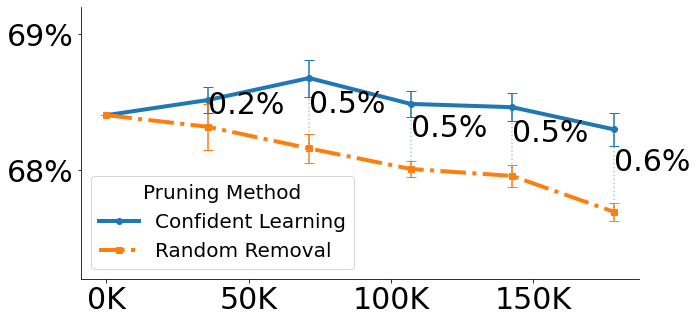

/home/cgn/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:147: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/cgn/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:150: UserWarning: FixedFormatter should only be used together with FixedLocator


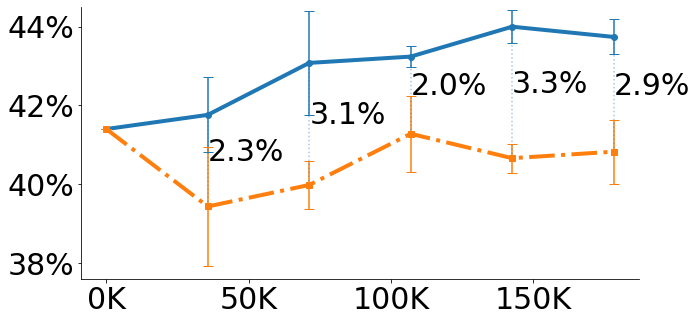

/home/cgn/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:147: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/cgn/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:150: UserWarning: FixedFormatter should only be used together with FixedLocator


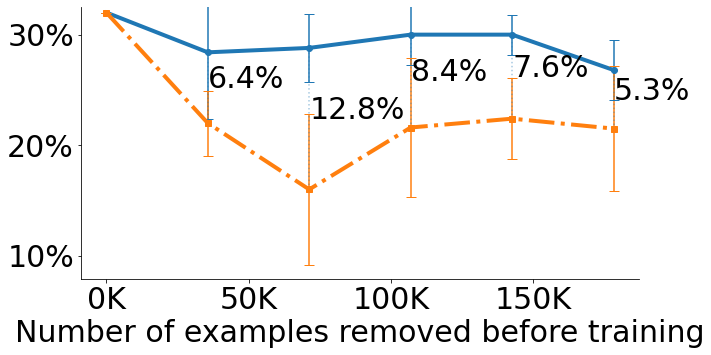

/home/cgn/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:147: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/cgn/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:150: UserWarning: FixedFormatter should only be used together with FixedLocator


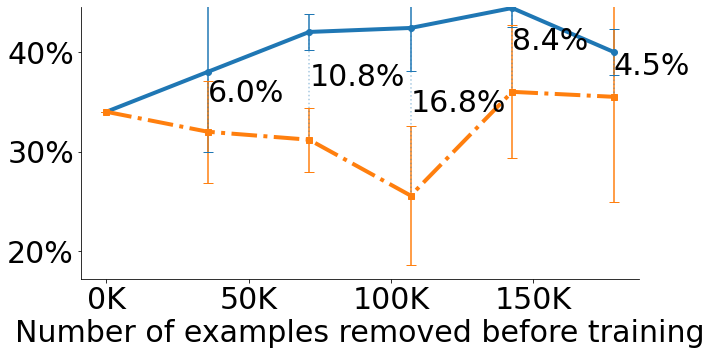

In [43]:
ci = 90
savefig = True
model_names = ['resnet18']

for model_name in model_names:
    title = "{}_imagenet_comparison_cl_methods_5_trials".format(model_name)
    plot_data_per_trial = {trial: {k:np.mean(v) for k,v in acc1s_per_trial[trial].items() if model_name in k} for trial in range(1, 6)}
    x_rand, y_cls_mean, y_cls_std, y_rands_mean, y_rands_std, acc_zero_removed = \
            get_mean_std_of_y_cl_and_y_rand(plot_data_per_trial, confidence_interval=ci)
    # Convert 
    make_plot2(x_rand, y_cls_mean, y_cls_std, y_rands_mean, y_rands_std,
               acc_zero_removed, title=title, savefig=savefig, force_yaxis=True,
               plot_xlabel=False, legend_loc='lower left',
               plot_legend='resnet18')

for model_name in model_names:
    title = r"{} Acc of 20 noisiest classes_5_trials".format(model_name)
    plot_data_per_trial = {trial: {k:np.mean([v[i] for i in forty_noisiest_classes[:20]]) for k,v in acc1s_per_trial[trial].items() if model_name in k} for trial in range(1, 6)}
    x_rand, y_cls_mean, y_cls_std, y_rands_mean, y_rands_std, acc_zero_removed = \
            get_mean_std_of_y_cl_and_y_rand(plot_data_per_trial, confidence_interval=ci)
    make_plot2(x_rand, y_cls_mean, y_cls_std, y_rands_mean, y_rands_std,
               acc_zero_removed, title=title, savefig=savefig,
               plot_legend=False, plot_xlabel=False, plot_title=False)

for model_name in model_names:
    assert(nid2name[idx2nid[smallest_diag_idx]] == "English_foxhound")
    title = '{} Acc of noisiest class {}_5_trials'.format(model_name, 'foxhound')
    plot_data_per_trial = {trial: {k:v[smallest_diag_idx] for k,v in acc1s_per_trial[trial].items() if model_name in k} for trial in range(1, 6)}
    x_rand, y_cls_mean, y_cls_std, y_rands_mean, y_rands_std, acc_zero_removed = \
            get_mean_std_of_y_cl_and_y_rand(plot_data_per_trial, confidence_interval=ci)
    make_plot2(x_rand, y_cls_mean, y_cls_std, y_rands_mean, y_rands_std,
               acc_zero_removed, title=title, savefig=savefig,
               plot_legend=False, plot_xlabel=True, plot_title=False)

for model_name in model_names:
    title = '{} Acc of a noisy class {}_5_trials'.format(model_name, nid2name[idx2nid[maillot_class_id]])
    plot_data_per_trial = {trial: {k:v[maillot_class_id] for k,v in acc1s_per_trial[trial].items() if model_name in k} for trial in range(1, 6)}
    x_rand, y_cls_mean, y_cls_std, y_rands_mean, y_rands_std, acc_zero_removed = \
            get_mean_std_of_y_cl_and_y_rand(plot_data_per_trial, confidence_interval=ci)
    make_plot2(x_rand, y_cls_mean, y_cls_std, y_rands_mean, y_rands_std,
               acc_zero_removed, title=title, savefig=savefig,
               plot_legend=False, plot_xlabel=True, plot_title=False)

# Scratch work below here

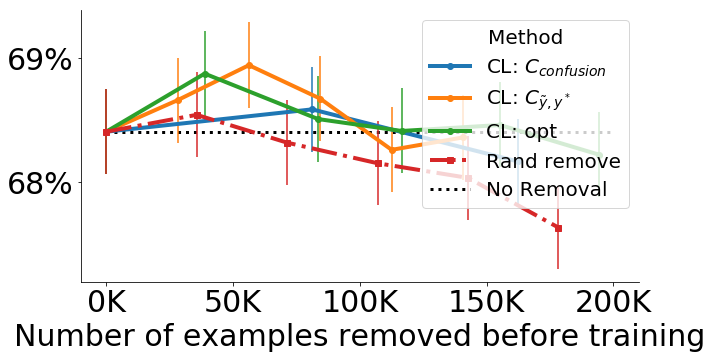

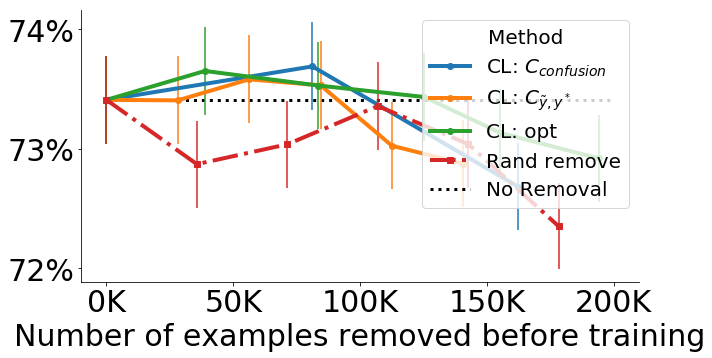

In [201]:
for model_name in ['resnet18', 'resnet50']:
    plot_data = {k:np.mean(v) for k,v in acc1s.items() if model_name in k}
    # Remove last three points of cl baseline
    if model_name == 'resnet50':
        for z in ['_60_argmax', '_80_argmax', '_100_argmax']:
            del plot_data[model_name + z]
    if model_name == 'resnet18':
#         del plot_data['resnet18_100_cj_only']
#         del plot_data['resnet18_60_cj_only']
        del plot_data['resnet18_60_argmax']
        del plot_data['resnet18_100_argmax']
    make_plot(
        plot_data,
        title="{}_imagenet_comparison_cl_methods".format(model_name),
        text_round=1, 
        savefig=True,
        plot_xlabel=True,
        legend_loc='upper right',
        legend_ncols=1,
        use_cl_opt=True,  # model_name=='resnet50',
        force_yaxis=True,
        plt_error_bars=True,
    )

[67, 102, 69]


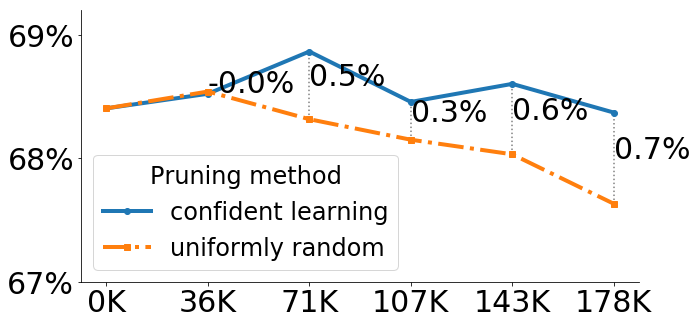

[72, 110, 74]


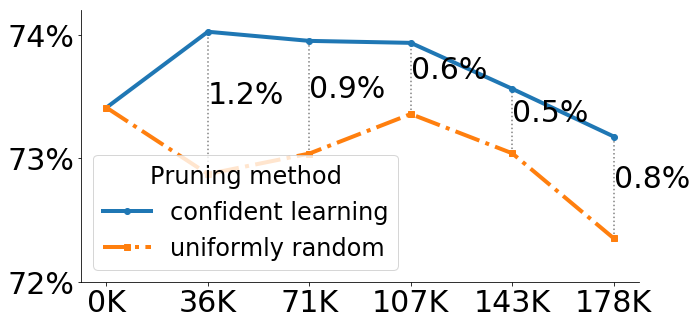

In [166]:
for model_name in ['resnet18', 'resnet50']:
    plot_data = {k:np.mean(v) for k,v in acc1s.items() if model_name in k}
    make_plot(plot_data, title = "{} ImageNet Validation Acc".format(model_name), text_round = 1, savefig = True, plot_xlabel = False)

In [64]:
for model_name in ['resnet18', 'resnet50']:
        scores = np.array(acc1s['{}_00'.format(model_name)]) + np.array(acc1s['{}_20random'.format(model_name)]) - np.array(acc1s['{}_20_both'.format(model_name)])
        for j in range(40, 101, 20):
            scores += np.array(acc1s['{}_00'.format(model_name)]) + np.array(acc1s['{}_{}random'.format(model_name, j)]) - np.array(acc1s['{}_{}_both'.format(model_name, j)])
        best_class_idx = np.argmin(scores)
        plot_data = {k:np.mean(v[best_class_idx]) for k,v in acc1s.items() if model_name in k}
#         title = r"{} Acc of {} noisiest classes".format(model_name, j)
        # Remove last three points of cl baseline
        if model_name == 'resnet50':
            for z in ['_60_argmax', '_80_argmax', '_100_argmax']:
                del plot_data[model_name + z]
        if model_name == 'resnet18':
            del plot_data['resnet18_80_cj_only']
#             del plot_data['resnet18_40_cj_only']
            del plot_data['resnet18_60_cj_only']
            del plot_data['resnet18_100_cj_only']
            del plot_data['resnet18_60_argmax']
            del plot_data['resnet18_100_argmax']
#         print(title)
        sys.stdout.flush()
        make_plot(
            plot_data,
            title=title,
            text_round=1, 
            savefig=False,
            plot_xlabel=False,
            legend_loc='upper right',
            legend_ncols=1,
            use_cl_opt=model_name=='resnet50',
        )
        plt.show()
#     make_plot(plot_data, title = title, savefig = False, plot_legend = False, plot_xlabel = False)

NameError: name 'title' is not defined

resnet18 Acc of 50 noisiest classes


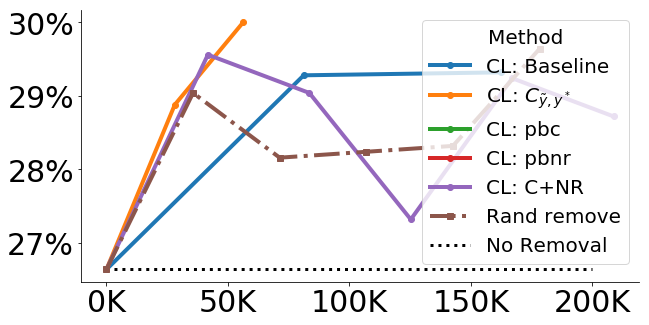

resnet18 Acc of 100 noisiest classes


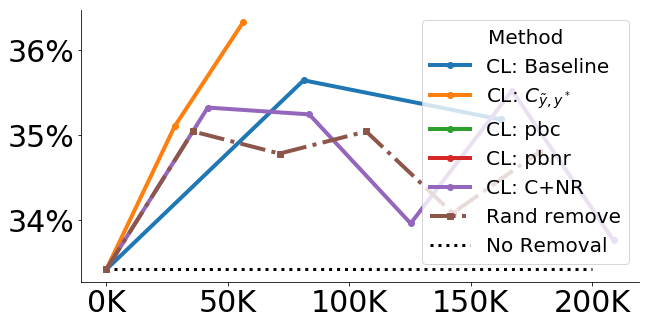

resnet18 Acc of 150 noisiest classes


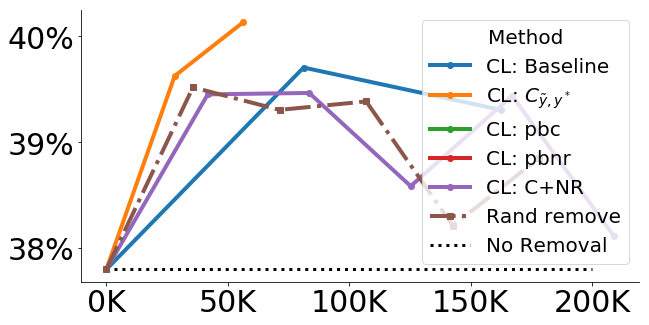

resnet18 Acc of 200 noisiest classes


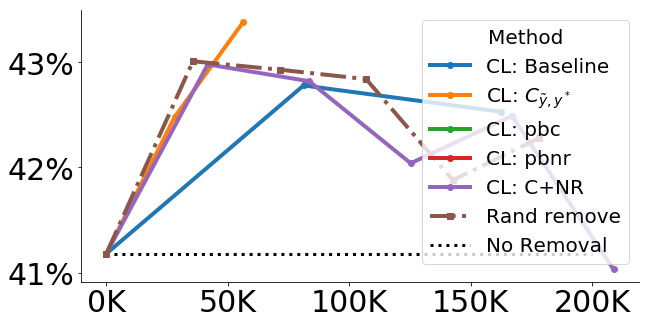

resnet50 Acc of 50 noisiest classes


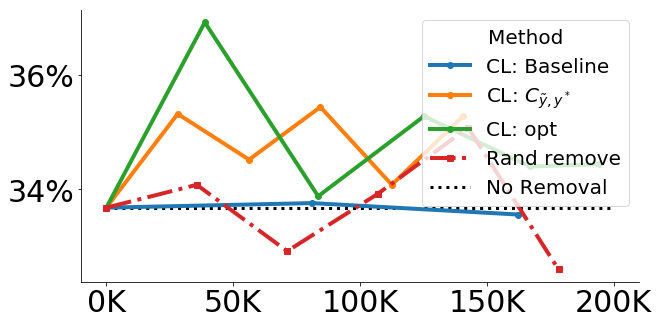

resnet50 Acc of 100 noisiest classes


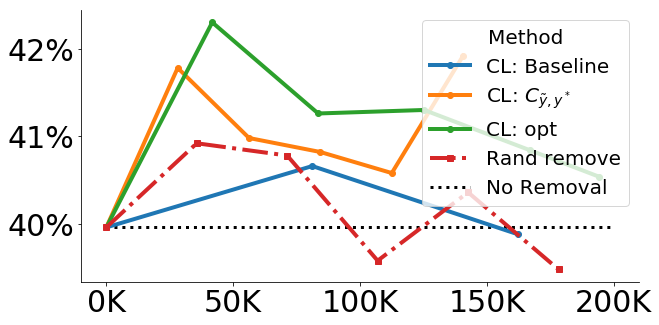

resnet50 Acc of 150 noisiest classes


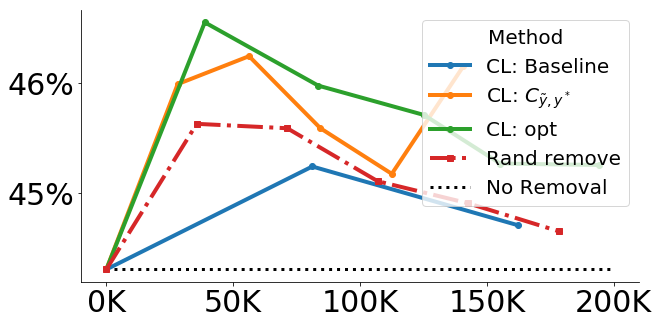

resnet50 Acc of 200 noisiest classes


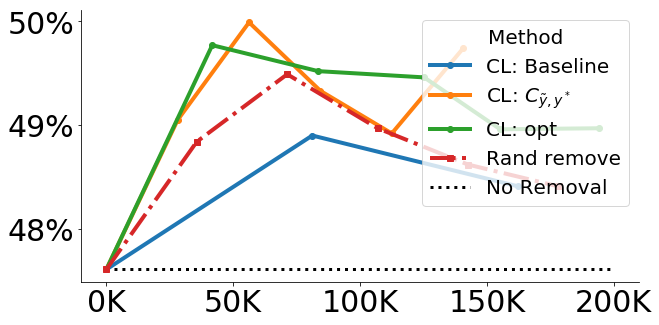

In [97]:
for model_name in ['resnet18', 'resnet50']:
    for j in list(range(50, 201, 50)):
        noisest_classes = np.argsort(acc1s['{}_00'.format(model_name)])
        plot_data = {k:np.mean([v[i] for i in noisest_classes[:j]]) for k,v in acc1s.items() if model_name in k}
        title = r"{} Acc of {} noisiest classes".format(model_name, j)
        # Remove last three points of cl baseline
        if model_name == 'resnet50':
            for z in ['_60_argmax', '_80_argmax', '_100_argmax']:
                del plot_data[model_name + z]
        if model_name == 'resnet18':
            del plot_data['resnet18_80_cj_only']
#             del plot_data['resnet18_40_cj_only']
            del plot_data['resnet18_60_cj_only']
            del plot_data['resnet18_100_cj_only']
            del plot_data['resnet18_60_argmax']
            del plot_data['resnet18_100_argmax']
        print(title)
        sys.stdout.flush()
        make_plot(
            plot_data,
            title=title,
            text_round=1, 
            savefig=False,
            plot_xlabel=False,
            legend_loc='upper right',
            legend_ncols=1,
            use_cl_opt=model_name=='resnet50',
        )
        plt.show()
#     make_plot(plot_data, title = title, savefig = False, plot_legend = False, plot_xlabel = False)

[37, 62, 44]


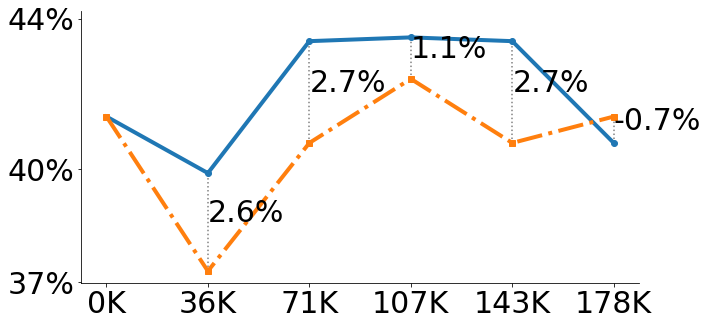

[43, 70, 49]


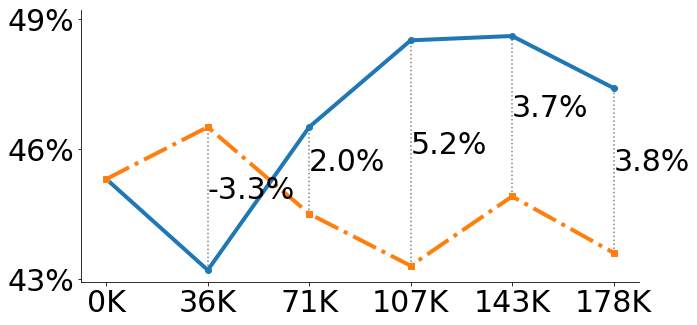

In [167]:
for model_name in ['resnet18', 'resnet50']:
    plot_data = {k:np.mean([v[i] for i in forty_noisiest_classes[:20]]) for k,v in acc1s.items() if model_name in k}
    title = r"{} Acc of 20 noisiest classes".format(model_name)
    make_plot(plot_data, title = title, savefig = True, plot_legend = False, plot_xlabel = False)

x_rand (0, 35658, 71317, 106976, 142635, 178294)
x_cl_both (0, 41765, 83531, 125296, 167062, 208828)
x_cl_cj_only (0, 28138, 84415, 140693)
x_cl_argmax (0, 81212, 162424)
x_rand (0, 35658, 71317, 106976, 142635, 178294)
x_cl_both (0, 41765, 83531, 125296, 167062, 208828)
x_cl_cj_only (0, 28138, 56277, 84415, 112554, 140693)
x_cl_argmax (0, 81212, 162424)


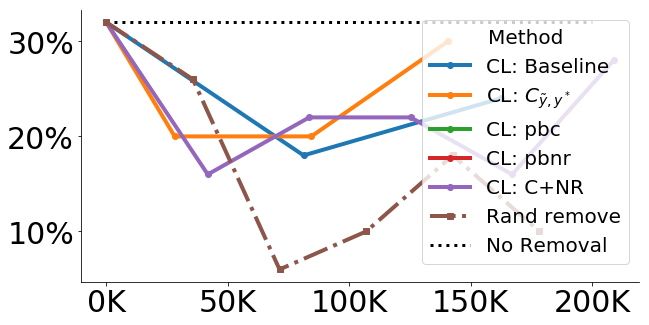

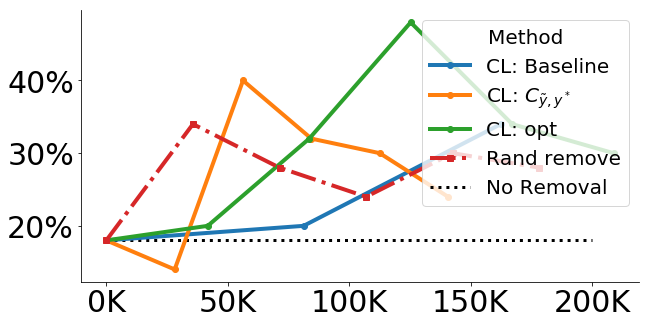

In [44]:
for model_name in ['resnet18', 'resnet50']:
    assert(nid2name[idx2nid[smallest_diag_idx]] == "English_foxhound")
    plot_data = {k:v[smallest_diag_idx] for k,v in acc1s.items() if model_name in k}
    # Remove last three points of cl baseline
    if model_name == 'resnet50':
        for z in ['_60_argmax', '_80_argmax', '_100_argmax']:
            del plot_data[model_name + z]
    if model_name == 'resnet18':
        del plot_data['resnet18_80_cj_only']
        del plot_data['resnet18_40_cj_only']
        del plot_data['resnet18_60_argmax']
        del plot_data['resnet18_100_argmax']
    title = '{} Acc of noisiest class: {}'.format(model_name, 'foxhound')
    make_plot(
        plot_data,
        title="{} ImageNet Validation Acc".format(model_name),
        text_round=1, 
        savefig=False,
        plot_xlabel=False,
        legend_loc='upper right',
        legend_ncols=1,
        use_cl_opt=model_name=='resnet50',
    )
      

[6, 37, 34]


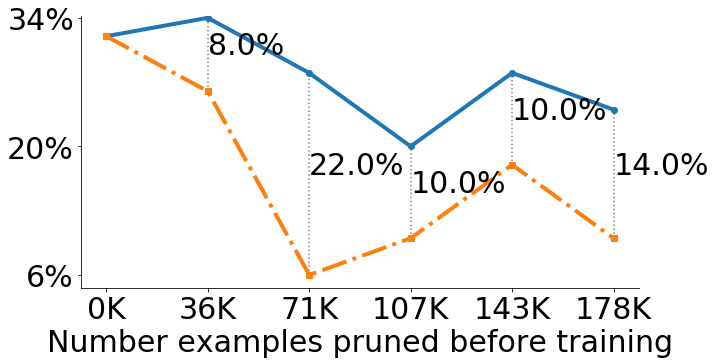

[18, 43, 34]


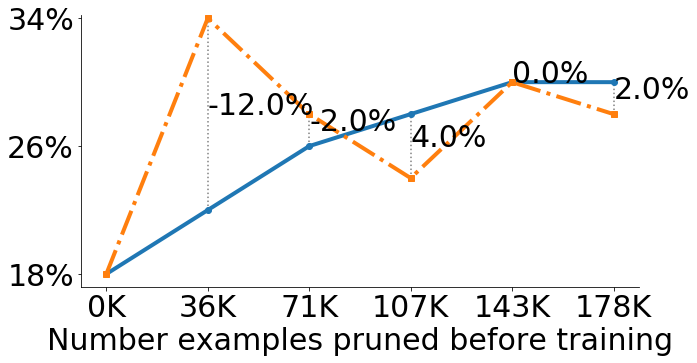

In [168]:
for model_name in ['resnet18', 'resnet50']:
    assert(nid2name[idx2nid[smallest_diag_idx]] == "English_foxhound")
    plot_data = {k:v[smallest_diag_idx] for k,v in acc1s.items() if model_name in k}
    title = '{} Acc of noisiest class: {}'.format(model_name, 'foxhound')
    make_plot(plot_data, title = title, savefig = True, plot_legend = False)

x_rand (0, 35658, 71317, 106976, 142635, 178294)
x_cl_both (0, 41765, 83531, 125296, 167062, 208828)
x_cl_cj_only (0, 28138, 112554)
x_cl_argmax (0, 81212, 162424)
x_rand (0, 35658, 71317, 106976, 142635, 178294)
x_cl_both (0, 41765, 83531, 125296, 167062, 208828)
x_cl_cj_only (0, 28138, 56277, 84415, 112554, 140693)
x_cl_argmax (0, 81212, 162424)


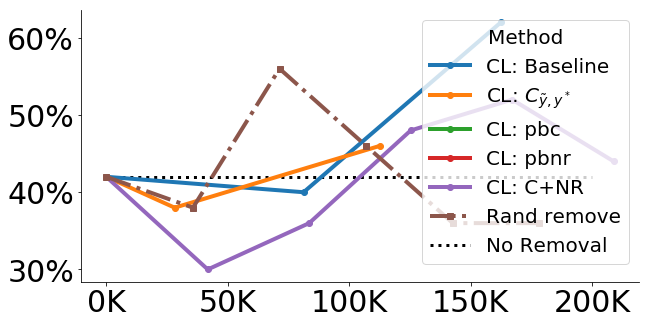

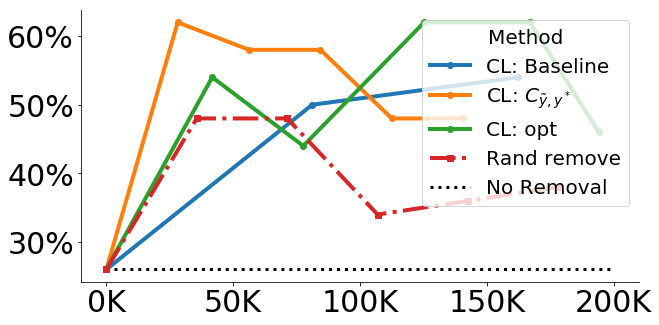

In [45]:
for model_name in ['resnet18', 'resnet50']:
    plot_data = {k:v[largest_non_diag_idx] for k,v in acc1s.items() if model_name in k}
    title = '{} Acc of a noisy class: {}'.format(model_name, nid2name[idx2nid[largest_non_diag_idx]])
    # Remove last three points of cl baseline
    if model_name == 'resnet50':
        for z in ['_60_argmax', '_80_argmax', '_100_argmax']:
            del plot_data[model_name + z]
    if model_name == 'resnet18':
        del plot_data['resnet18_100_cj_only']
        del plot_data['resnet18_60_cj_only']
        del plot_data['resnet18_40_cj_only']
        del plot_data['resnet18_60_argmax']
        del plot_data['resnet18_100_argmax']
    make_plot(
        plot_data,
        title="{} ImageNet Validation Acc".format(model_name),
        text_round=1, 
        savefig=False,
        plot_xlabel=False,
        legend_loc='upper right',
        legend_ncols=1,
        use_cl_opt=model_name=='resnet50',
    )

[46, 93, 70]


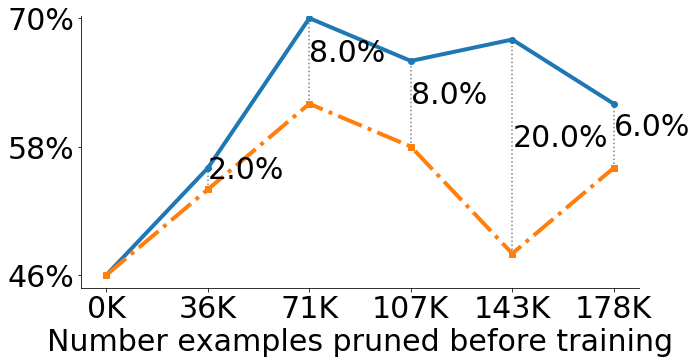

[50, 111, 86]


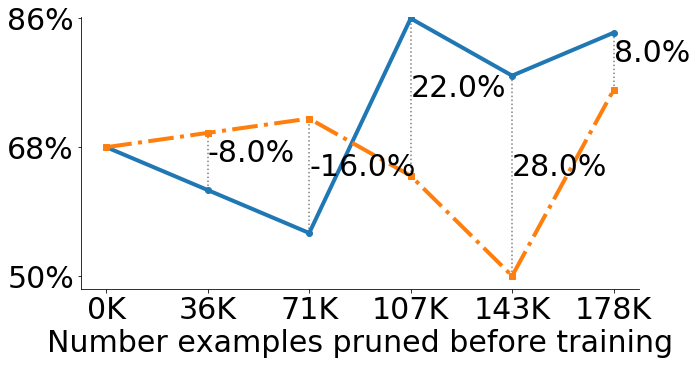

In [169]:
for model_name in ['resnet18', 'resnet50']:
    plot_data = {k:v[largest_non_diag_idx] for k,v in acc1s.items() if model_name in k}
    title = '{} Acc of a noisy class: {}'.format(model_name, nid2name[idx2nid[largest_non_diag_idx]])
    make_plot(plot_data, title = title, savefig = True, plot_legend = False)

In [ ]:
PyTorch 1.0  resnet152          77.62%  93.81%  3       3
PyTorch 1.0  resnet50           75.06%  92.48%  10      10
PyTorch 1.0  densenet121        74.07%  91.94%  12      12
PyTorch 1.0  resnet34           72.34%  90.84%  15      16
PyTorch 1.0  vgg16_bn           72.29%  91.01%  16      15
PyTorch 1.0  resnet18           68.37%  88.56%  28      26
PyTorch 1.0  alexnet            54.50%  77.64%  34      34

In [ ]:
Platform     Model              Acc@1   Acc@5   Rank@1  Rank@5
-----        -----              -----   ------  ------  -------
Keras 2.2.4  nasnetlarge        80.83%  95.27%  1       1
Keras 2.2.4  inceptionresnetv2  78.93%  94.45%  2       2
PyTorch 1.0  resnet152          77.62%  93.81%  3       3
Keras 2.2.4  xception           77.18%  93.49%  4       4
PyTorch 1.0  densenet161        76.92%  93.49%  5       5
PyTorch 1.0  resnet101          76.64%  93.30%  6       6
PyTorch 1.0  densenet201        76.41%  93.18%  7       7
Keras 2.2.4  inceptionv3        76.02%  92.90%  8       8
PyTorch 1.0  densenet169        75.59%  92.69%  9       9

Keras 2.2.4  densenet121        72.09%  90.70%  17      17
Keras 2.2.4  nasnetmobile       71.59%  90.19%  18      19
PyTorch 1.0  vgg19              71.19%  90.40%  19      18
PyTorch 1.0  vgg16              70.66%  89.93%  20      20
Keras 2.2.4  resnet50           70.35%  89.55%  21      22
PyTorch 1.0  vgg13_bn           70.12%  89.56%  22      21
Keras 2.2.4  mobilenetV2        69.98%  89.49%  23      23
PyTorch 1.0  vgg11_bn           69.36%  89.06%  24      24
PyTorch 1.0  inception_v3       69.25%  88.69%  25      25
Keras 2.2.4  mobilenet          69.02%  88.48%  26      27
PyTorch 1.0  vgg13              68.69%  88.65%  27      28
PyTorch 1.0  resnet18           68.37%  88.56%  28      26
PyTorch 1.0  vgg11              67.85%  88.11%  29      29
Keras 2.2.4  vgg19              65.58%  86.54%  30      30
Keras 2.2.4  vgg16              65.24%  86.20%  31      31
PyTorch 1.0  squeezenet1_0      56.49%  79.06%  32      33
PyTorch 1.0  squeezenet1_1      56.42%  79.21%  33      32
PyTorch 1.0  alexnet            54.50%  77.64%  34      34